#Settings

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchinfo import summary
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from IPython.display import Image
import os

if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')

Some Adjustments Needed For Displaying Images Nicely

In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [ ]:
cuda =  False #True
DEVICE = torch.device("cuda" if cuda else "cpu")

Set the cuda parameter to True if you have GPU access.

#Demonstration Of Some Basic Matrix Handling Techniques

You would need to know these techniques to understand the main code which is on the VAE.

In [ ]:
arr1 = [[1, 2,4], [3, 4,5]]
arr1 = np.array(arr1)
arr1 = torch.tensor(arr1)
arr1.pow(2)

tensor([[ 1,  4, 16],
        [ 9, 16, 25]])

In [ ]:
arr2 = [[1, 1,1], [0, 0,0]]
arr2 = np.array(arr2)
arr2 = torch.tensor(arr2)
1 + arr2

tensor([[2, 2, 2],
        [1, 1, 1]])

In [ ]:
arr2.exp()

tensor([[2.7183, 2.7183, 2.7183],
        [1.0000, 1.0000, 1.0000]])

In [ ]:
arr1.pow(2) + 1 + arr2 + arr2.exp()

tensor([[ 5.7183,  8.7183, 20.7183],
        [11.0000, 18.0000, 27.0000]])

In [ ]:
torch.sum(arr1.pow(2) + 1 + arr2 + arr2.exp())

tensor(91.1548)

#Demonstration On Plotting Heat Maps
You would need to know these techniques for the assessed coursework.

In [ ]:
data = np.random.rand(3,4)

for i in range(3):
  for j in range(4):
     data[i][j]=(i+j)**3

print(data)

[[  0.   1.   8.  27.]
 [  1.   8.  27.  64.]
 [  8.  27.  64. 125.]]


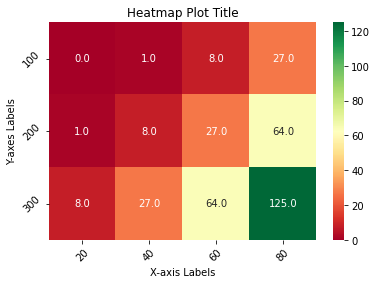

In [ ]:
#vmin- minimum colour range value
#vmax - maximum colour range value

text_str=[]
for i in range(len(data)):
  x=[]
  for j in range(len(data[0])):
    x.append(str(data[i][j]))
  text_str.append(x)


ax = sns.heatmap(data, cmap='RdYlGn',vmin=0, vmax=5**3, annot=text_str,fmt="")

plt.xticks([0.5,1.5,2.5,3.5],['20','40','60','80'],rotation=45)
plt.yticks([0.5,1.5,2.5],('100','200','300'),rotation=45)

#We are imagining that the squares in the heat-map are function values corresponding to domain points, [20,40,60,80]x[100,200,300]
plt.title("Heatmap Plot Title")
plt.xlabel("X-axis Labels")
plt.ylabel("Y-axes Labels")


plt.show()

#Defining The Net

In [ ]:
class FCAutoEncoder(nn.Module):
      def __init__(self, input_size, hidden_size):
          super().__init__()
          self.fc1 = nn.Linear(input_size, hidden_size)
          self.fc2 = nn.Linear(hidden_size, hidden_size)
          self.fc3 = nn.Linear(hidden_size, input_size)


      def forward(self, x):
          x = x.view(x.size(0), -1)
          #If B is the mini-batch size sent to forward then x.size(0) = B
          #The "-1" vectorizes the image i.e for MNIST it created a 28x28 0/1 vector
          #So if  B is the mini-batch size then x.view(x.size(0), -1) gives as output a matrix of dimensions B x 28^2
          x = self.fc1(x)
          x = nn.functional.relu(x)
          x = self.fc2(x)
          x = nn.functional.relu(x)
          x = self.fc3(x)
          return x

Here is what the "forward" function above is doing on any single image.

For the MNIST dataset let any single image (vectorized) be denoted as, $\vec{z}$, a $28^2$ dimensional 0/1 vector


And on it the "forward" function is implementing the following neural net map,
$$\mathbb{R}^{28^2} \ni  \vec{z} \rightarrow A_3 \circ {\rm ReLU} ( A_2 \circ  {\rm ReLU} (A_1(\vec{z}))) := {\cal N}(\vec{z}) \in \mathbb{R}^{28^2}$$

where, the following are the affine transforms being trained,

$$A_1 : {\mathbb R}^{28^2} \rightarrow {\mathbb R}^{\rm hidden-size}$$
$$A_2 : {\mathbb R}^{\rm hidden-size} \rightarrow {\mathbb R}^{\rm hidden-size}$$
$$A_3 : {\mathbb R}^{\rm hidden-size} \rightarrow {\mathbb R}^{28^2}$$

This is a depth $3$ neural network since it has $2$ layers of activation and $3$ layers of affine transforms.

> ${\bf Question :}$ What are the total number of parameters being trained here?
>
> Your answer should be in terms of the variable ${\rm hidden{-}size}$.




#Dataset Generator

In [ ]:
def Data_Generator(sample_size,batch_size):

    trainset = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor()
    )

    #trainset tensor contains images in its 0-axis and its labelling in its 1-axis
    #So trainset[n][1] picks out the label associated with the image indexed "n"

    training_numbers = [n for n in range(len(trainset)) if trainset[n][1]==3]
    training_numbers = training_numbers[:sample_size]

    #In above we extract the indices of a sample_size number of "3" images from the full MNIST data-set

    dataset = torch.utils.data.Subset(trainset, training_numbers)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #Here the dataloader splits the sample_size number of 3 images into a disjoint union of subsets each of size batch_size
    #These small batch_size sized subsets will eventually become the mini-batches that the SGD algorithm uses to compute the stochastic gradient.
    #Though for now we shall be just having a single mini-batch which is the whole training data and hence this would be just doing GD.

    return dataloader


The above code picks out a ${\tt sample\_size}$ number of  images of 3 from the full MNIST dataset and splits this set of images into a disjoint number of subsets of size ${\tt batch\_size}$. If we represent the images by letters, then suppose for illustration that ${\tt sample\_size} = 4$ and the ${\tt dataset} = \{ a,b,c,d\}$ (after some random ${\tt shuffle}$/permutation has been applied) and ${\tt batch\_size = 2}$. Then ${\tt dataloader}$ will effectively queue up this training data as the sequence of subsets, $\{ a,b\},\{c,d\}$.

> **Exercise** :  Have fun repeating the code for other digits or when this code is made to work with multiple digits at the same time!

#Hyperparameters

In [ ]:
sample_size = 2**10
batch_size = sample_size

num_epochs = 200 #Number of times we go through the entire sample-size set of 3s that we have extracted from the dataset

learning_rate = 1e-4

input_size = 28*28
autoencoder_width = 500 #the hidden-size in the net i.e the number of ReLU gates in each activation layer

>**Question** : The above crucially sets ${\tt batch\_size} = {\tt sample\_size}$. Upon doing this is this code running a stochastic gradient descent? Explain your argument!

Generate Random Vectors That Are Needed For Training

In [ ]:
zs = torch.rand(sample_size, input_size).to(DEVICE)

#Doing The Neural Training

In [ ]:
model = FCAutoEncoder(input_size, autoencoder_width).to(DEVICE)
summary(model,(1,input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
            Linear-2                  [-1, 500]         250,500
            Linear-3                  [-1, 784]         392,784
Total params: 1,035,784
Trainable params: 1,035,784
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.95
Estimated Total Size (MB): 3.97
----------------------------------------------------------------


> **Exercise :** Reproduce via explicit calculation the above parameter count for whatever autoencoder you are testing on.

In [ ]:
criterion = nn.MSELoss()
#Chooses the squared-loss for training

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
#fixes the optimization algorithm to the basic SGD with a step-length of lr and a Frobenius norm regularization weighted by weight-decay

dataloader = Data_Generator(sample_size,batch_size)
#creates the mini-batch split of the sample_size number of training data into disjoint subsets of size batch_size

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw





>**NOTE:** A very key complication above is the fact that we have to set the optimizer to ADAM. This is a somewhat complicated optimization algorithm and (unfortunately!) this experiments is essentially impossible to run with anything simpler! So it kind of becomes critical that we know what this algoritm exactly is : See Algorithm 3 in this paper of ours, . $\href{https://arxiv.org/pdf/1807.06766.pdf}{\color{violet}(link)}$

> In the upcoming code block when the optimization is actually done we will indicate in the comments as to which steps in the code correspond to which steps in the pseudocode referred above.  



If we let $\lambda =$ weight_decay and let the $S=$ sample_size number of training data be denoted as $(\vec{z}_i,\vec{y}_i)$ for $i=1,\ldots,S$, then the loss function that is effectively now getting minimized for this map ${\cal N}$ (over its affine transforms) defined earlier is as follows,

$${\cal L}_{\rm Empirical-Risk}(A_1,A_2,A_3) = \frac{1}{S} \cdot \sum_{i=1}^S \Vert \vec{y}_i - {\cal N}(\vec{z}_i) \Vert_2^2 + \lambda \cdot ( \Vert A_1\Vert^2 + \Vert A_2 \Vert ^2 + \Vert A_3 \Vert^2 )$$

> Notice how in the above loss function the autoencoder ${\cal N}$ (mapping 784 dimension to 784 dimensions) is trying to create the meaningful images $\vec{y}_i$ from noise samples $\vec{z}_i$.  Hence albeit the above is a loss function on an autoencoder (like what you saw in the slides and the first 2 videos) the objective isnt to recreate the input images as was happening there.  

In [ ]:
for epoch in range(num_epochs+1):

    for data in dataloader:
        img, _ = data
        img = img.view(img.shape[0], -1).to(DEVICE)

        #img gets the image part of the data i.e the current mini-batch
        #So img.shape[0] = the mini-batch size = batch_size (which for now is also = sample_size)
        #The last command above reshapes the img into a mini-batch size x 28^2 dimensional matrix
        #So each vectorized image is now a row in the matrix img
        #And the whole matrix of these vectors have now been assigned to the DEVICE which is GPU or CPU depending on the configuration.

        output = model(zs).to(DEVICE)
        #Output of the current autoencoder on  the random data which is a batch_size (=sample_size) x input_size matrix

        loss = criterion(output, img)
        #The regularized loss gets computed above.

        optimizer.zero_grad()
        loss.backward()
        #The above computes the gradient w.r.t the affine transforms of the regularized loss L_{Empirical-Risk} defined above.
        #loss.backward() = g_t in Step-5 in Algorithm 3 here, https://arxiv.org/pdf/1807.06766.pdf
        optimizer.step()
        #Suppose we define W_t = the collective vector of weights of the nets i.e all the parameters in the 3 affine transforms in the net.
        #The above implements the  update step from W_t to W_{t+1} i.e Step-9 in Algorithm 3 in https://arxiv.org/pdf/1807.06766.pdf


    if epoch % 20 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './dc_img/image_{}.png'.format(epoch))
        print('epoch [{}/{}], loss:{:.4f}'
         .format(epoch, num_epochs, loss))

epoch [0/200], loss:0.1242
epoch [20/200], loss:0.0712
epoch [40/200], loss:0.0587
epoch [60/200], loss:0.0581
epoch [80/200], loss:0.0579
epoch [100/200], loss:0.0578
epoch [120/200], loss:0.0578
epoch [140/200], loss:0.0578
epoch [160/200], loss:0.0577
epoch [180/200], loss:0.0577
epoch [200/200], loss:0.0577


> **Exercise :** Install a plotter in the above to visualize how the training loss (or empirical risk) is changing with the epochs.

>**Exercise** : Repeat the above experiment using ${\tt batch\_size} \ll {\tt sample\_size}$. Is this Stochastic Gradient Descent? Explain your argument! Observe how you need to set the ${\tt batch\_size}$ (for a fixed ${\tt sample\_size}$) to get optimal performance i.e least value of the loss.

# Visualizing The Output & Discussions

Looking at the images saved from training - open the folder icon on the left bar.

In there we can see that the neural network learns to generate "3"s from random vectors zs.

Now, if we feed a set of new random vectors to the trained net, will it generate images of 3s as well?

Thats the real aim!! Lets see!



> **NOTE : The drawback of this experiment is that there is not much of any diversity among the outputs here for different random vector inputs to the trained net. It will take a lot more changing of this setup to bring some realistic variety in the outputs - so that it looks more believable as possible handwritings of different people.**



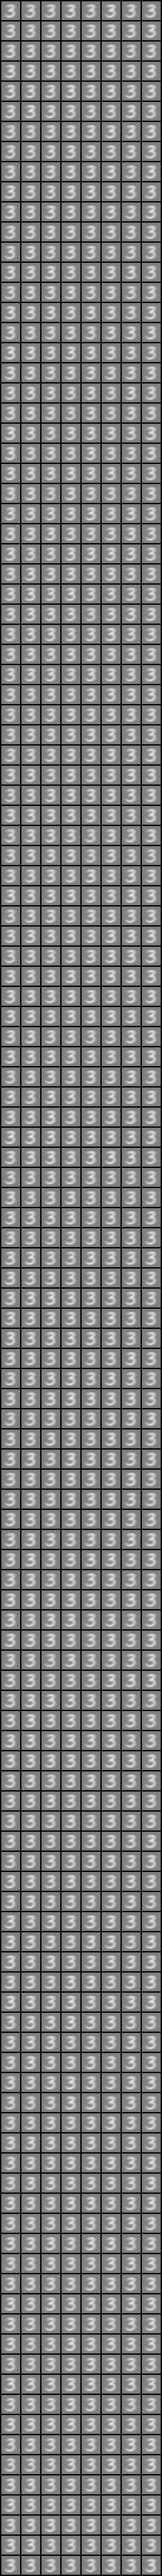

In [ ]:
#Sample a sample_size number of new random vecectors
# - which can be sent as input to the net i.e the forward function

z_new = torch.rand(sample_size, input_size).to(DEVICE)

yhat = model(z_new).cpu().detach()
#The above extracts the output of the trained "model" on these random vectors.

pic = to_img(yhat)
save_image(pic, './dc_img/image_newsample.png')

#Lets see what the outputs of the trained net look like on these random vectors!
Image(filename='./dc_img/image_newsample.png')